In [3]:
import sys
import os

src_path = os.path.abspath(os.path.join(os.pardir, "src"))
if src_path not in sys.path:
    sys.path.append(src_path)

from app import download_extract_zip_to_csv

download_extract_zip_to_csv(output_dir="../data")

Zip file downloaded successfully to: downloaded_data.zip
Extracting CSV files...
Found CSV file: Fake.csv
CSV file saved to: ../data/Fake.csv
Found CSV file: True.csv
CSV file saved to: ../data/True.csv
Deleted the downloaded zip file: downloaded_data.zip


True

[nltk_data] Downloading package punkt to /home/cquark/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/cquark/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Numéricas: 7 ['text_length', 'title_length', 'num_exclamations', 'num_questions', 'num_uppercase_words', 'num_links', 'num_sentences']
Categóricas: 7 ['subject', 'month', 'weekday', 'title_has_exclamation', 'title_has_question', 'title_length_cat', 'title_has_link']
                       count         mean          std  min     25%     50%  \
text_length          44898.0  2469.109693  2171.617091  1.0  1234.0  2186.0   
title_length         44898.0    80.111542    25.379519  8.0    63.0    73.0   
num_exclamations     44898.0     0.407635     1.455699  0.0     0.0     0.0   
num_questions        44898.0     0.678605     1.794833  0.0     0.0     0.0   
num_uppercase_words  44898.0     7.866698    10.463373  0.0     2.0     5.0   
num_links            44898.0     0.104927     0.481492  0.0     0.0     0.0   
num_sentences        44898.0    14.871821    12.693722  0.0     7.0    13.0   

                        75%      max  
text_length          3105.0  51794.0  
title_length          

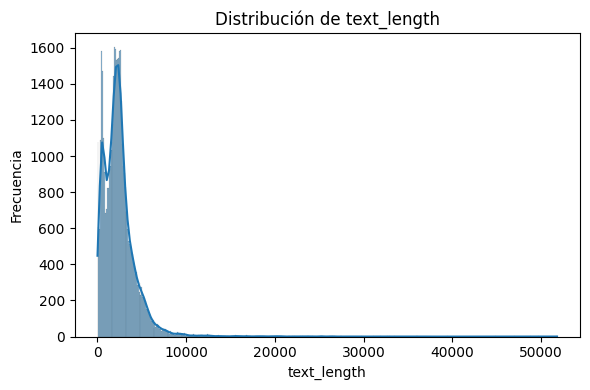

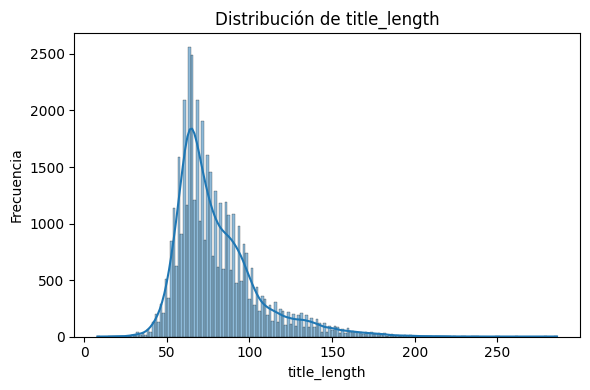

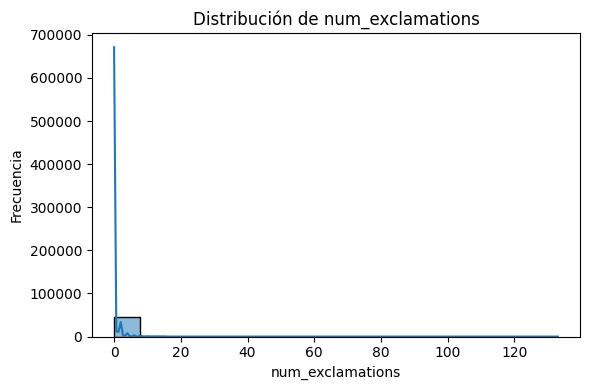

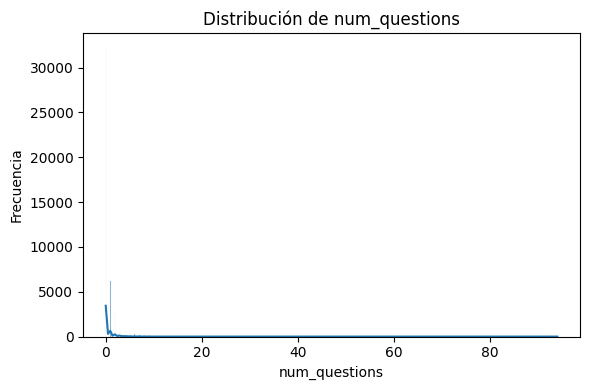

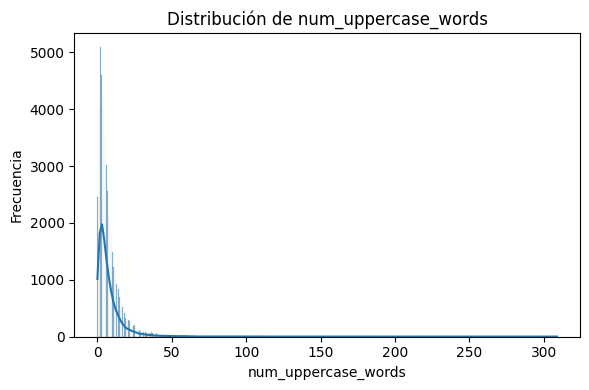

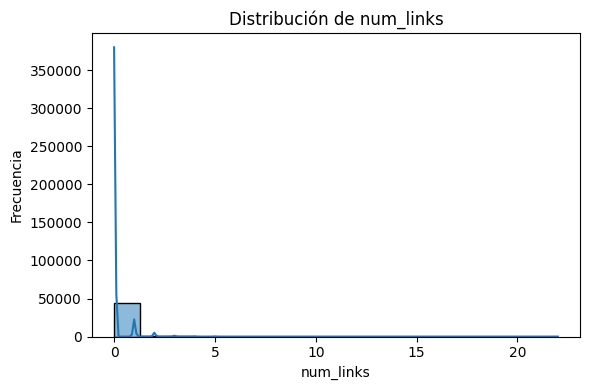

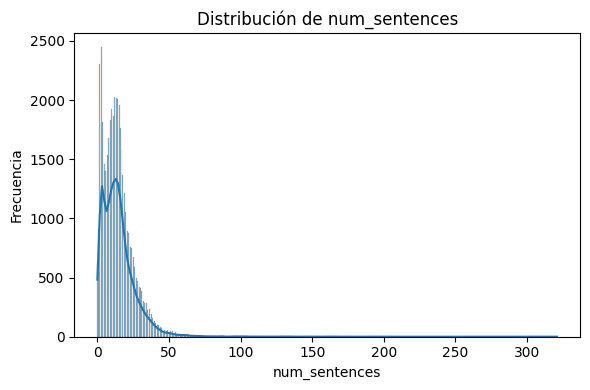


=== Distribución de subject ===


,count,percent
subject,,
politicsNews,11272,25.11
worldnews,10145,22.60
News,9050,20.16
politics,6841,15.24
left-news,4459,9.93
Government News,1570,3.50
US_News,783,1.74
Middle-east,778,1.73


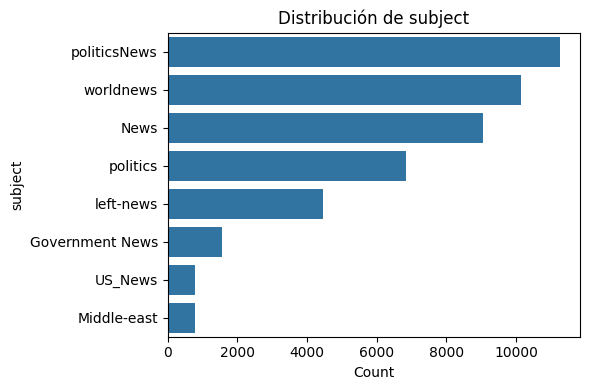


=== Distribución de month ===


,count,percent
month,,
NaN,33030,73.57
5.0,2177,4.85
1.0,1275,2.84
3.0,1220,2.72
2.0,1154,2.57
4.0,972,2.16
6.0,876,1.95
7.0,777,1.73
8.0,751,1.67


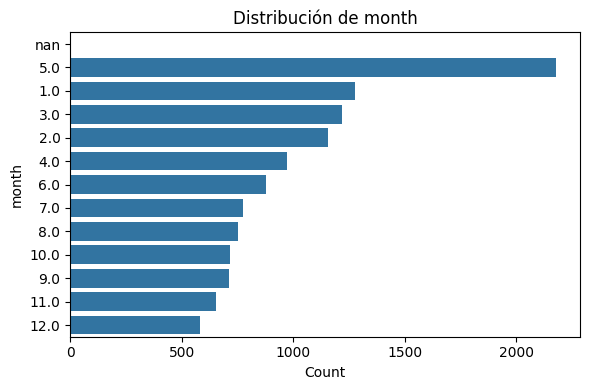


=== Distribución de weekday ===


,count,percent
weekday,,
NaN,33030,73.57
Thursday,1860,4.14
Wednesday,1829,4.07
Friday,1777,3.96
Tuesday,1764,3.93
Monday,1620,3.61
Sunday,1558,3.47
Saturday,1460,3.25


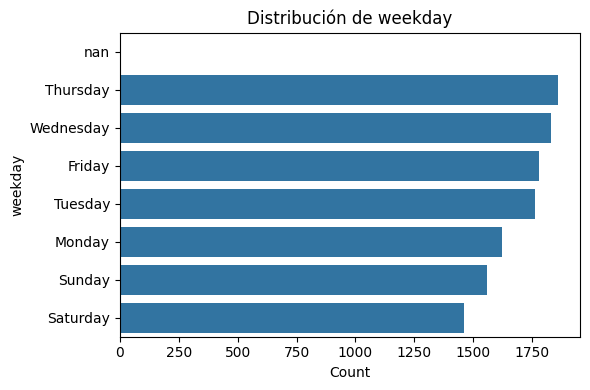


=== Distribución de title_has_exclamation ===


,count,percent
title_has_exclamation,,
no,41608,92.67
yes,3290,7.33


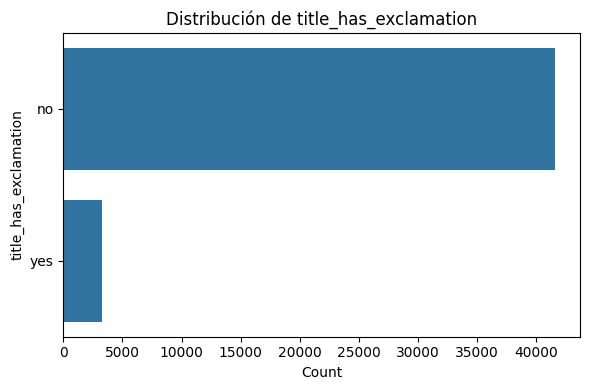


=== Distribución de title_has_question ===


,count,percent
title_has_question,,
no,43118,96.04
yes,1780,3.96


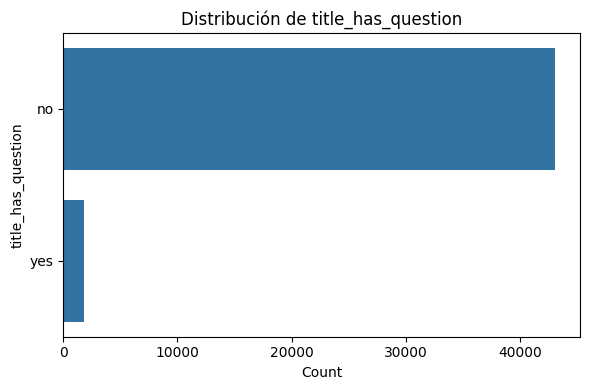


=== Distribución de title_length_cat ===


,count,percent
title_length_cat,,
long,25094,55.89
medium,19762,44.02
short,42,0.09


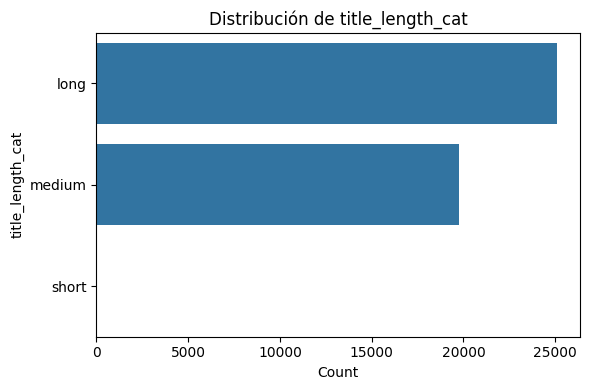


=== Distribución de title_has_link ===


,count,percent
title_has_link,,
no,44889,99.98
yes,9,0.02


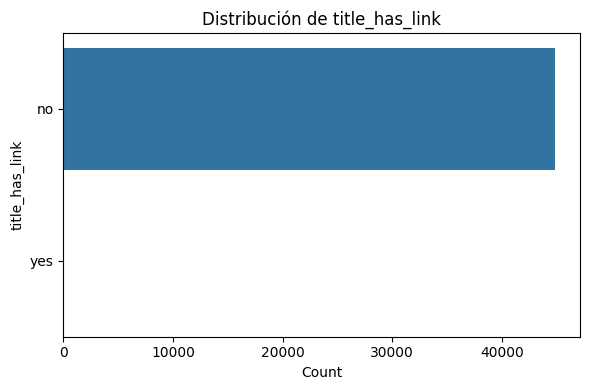

In [6]:
import pandas as pd
import nltk
import numpy as np
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')
nltk.download('punkt_tab')

df_fake = pd.read_csv('../data/Fake.csv')
df_real = pd.read_csv('../data/True.csv')
df = pd.concat([df_fake, df_real], ignore_index=True)
# Esta línea crea una columna 'label' en el DataFrame df.
# Asigna el valor 1 a las filas que provienen de df_fake (índices menores a len(df_fake)), y 0 a las que provienen de df_real.
df['label'] = df.index.map(lambda i: 1 if i < len(df_fake) else 0)

# 2) Numéricas (7)
df['text_length']           = df['text'].apply(len)
df['title_length']          = df['title'].apply(len)
df['num_exclamations']      = df['text'].str.count('!')
df['num_questions']         = df['text'].str.count('\?')
df['num_uppercase_words']   = df['text'].apply(lambda t: sum(1 for w in t.split() if w.isupper()))
df['num_links']             = df['text'].str.count('http')
df['num_sentences']         = df['text'].apply(lambda t: len(sent_tokenize(t)))

# 3) Categóricas (7)
# 3.1 El subject original
df['subject'] = df['subject'].astype('category')

# 3.2 Mes de la fecha
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['month'] = df['date'].dt.month.astype('category')

# 3.3 Día de la semana
df['weekday'] = df['date'].dt.day_name().astype('category')

# 3.4 ¿Contiene exclamación en el título?
df['title_has_exclamation'] = (df['title'].str.contains('!')).map({False:'no', True:'yes'}).astype('category')

# 3.5 ¿Contiene pregunta en el título?
df['title_has_question'] = (df['title'].str.contains('\?')).map({False:'no', True:'yes'}).astype('category')

# 3.6 Longitud del título en bins (corto/mediano/largo)
bins = [0, 30, 70, np.inf]
labels = ['short','medium','long']
df['title_length_cat'] = pd.cut(df['title_length'], bins=bins, labels=labels).astype('category')

# 3.7 ¿Hay enlaces en el título?
df['title_has_link'] = (df['title'].str.contains('http')).map({False:'no', True:'yes'}).astype('category')

# 4) Vista rápida
# Verifica que tienes 7 numéricas + 7 categóricas antes de modelar
num_cols = ['text_length','title_length','num_exclamations','num_questions',
            'num_uppercase_words','num_links','num_sentences']
cat_cols = ['subject','month','weekday','title_has_exclamation',
            'title_has_question','title_length_cat','title_has_link']

print("Numéricas:", len(num_cols), num_cols)
print("Categóricas:", len(cat_cols), cat_cols)

print(df[num_cols].describe().T)

# 2) Histogramas para cada variable numérica
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

# 3) Conteo y porcentaje para cada variable categórica
for col in cat_cols:
    vc = df[col].value_counts(dropna=False)
    pct = df[col].value_counts(normalize=True, dropna=False) * 100
    dist = pd.DataFrame({'count': vc, 'percent': pct.round(2)})
    print(f"\n=== Distribución de {col} ===")
    display(dist)

    # Gráfico de barras
    plt.figure(figsize=(6,4))
    sns.countplot(y=col, data=df, order=vc.index)
    plt.title(f'Distribución de {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

df.to_csv('../data/processed_data.csv', index=False)



In [7]:
import pandas as pd

df = pd.read_csv('../data/processed_data.csv')
df


/tmp/ipykernel_17996/20978617.py:3: DtypeWarning: Columns (3,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed_data.csv')


,title,text,subject,date,label,text_length,title_length,num_exclamations,num_questions,num_uppercase_words,num_links,num_sentences,month,weekday,title_has_exclamation,title_has_question,title_length_cat,title_has_link
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,1,2893,79,6,9,5,0,28,12.0,Sunday,no,no,long,no
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,1,1898,69,0,0,3,0,11,12.0,Sunday,no,no,medium,no
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,1,3597,90,2,4,42,1,25,12.0,Saturday,no,no,long,no
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,1,2774,78,0,1,5,4,15,12.0,Friday,no,no,long,no
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,1,2346,70,0,0,0,0,19,12.0,Monday,no,no,medium,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,NaN,0,2821,61,0,0,15,0,15,NaN,NaN,no,no,medium,no
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,NaN,0,800,52,0,0,1,0,6,NaN,NaN,no,no,medium,no
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,NaN,0,1950,49,0,0,5,0,16,NaN,NaN,no,no,medium,no
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,NaN,0,1199,61,0,0,1,0,8,NaN,NaN,no,no,medium,no
